<a href="https://colab.research.google.com/github/bfiegel/DeepLearningProject/blob/StacksHRMountain/Code/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Preparation and Utility Functions
Always Execute

In [173]:
!pip install biopython

import Bio
from Bio import SeqIO
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np 
import os
import pathlib
import PIL
import PIL.Image
import tarfile
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import urllib.request
from zipfile import ZipFile
import datetime

#Global Settings put here for convenience
useSampleData=False
trainingClass="lp64_224-Grass"

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs, this can be copied and moved to other places
# in the notebook
!rm -rf ./logs/ 

#import shutil
#shutil.rmtree('/content/drive')
os.chdir("/")
os.getcwd()

def DisplayTestImages(images, figsize=None, count=16):
  if (None == figsize):
    figsize=(16,16)
  plt.figure(figsize=figsize)
  dim = int(np.sqrt(count))
  images *= 255
  for i in range(dim**2):
    image = images[i]
    image = tf.keras.preprocessing.image.array_to_img(image)
#    image = tf.constant(images[i])
#    image = tf.image.convert_image_dtype(image, tf.uint8)
    #return PIL.Image.fromarray(image.numpy())
    ax = plt.subplot(dim, dim, i + 1)
    plt.imshow(image)
    plt.axis("off")

def prep_drive(doMount, dirsToMake):
  #mount google drive for longterm storage
  if True == doMount:
    mountPoint='/content/drive/'
    if not os.path.exists(mountPoint):
      drive.mount(mountPoint, force_remount=False)
  # create any directories that have been requested
  for d in dirsToMake:
    if not os.path.isdir(d):
      os.makedirs(d)

def download_and_extract_file(url, local_bundle_path, extraction_directory='.'):
  initial_directory = os.getcwd()
  os.chdir(extraction_directory)
  try:
    #only try to download and unbundle if it hasn't already been downloaded
    if not os.path.exists(local_bundle_path):
      # download the dataset
      urllib.request.urlretrieve(url,local_bundle_path )
      
      if local_bundle_path.endswith('.zip'):
        # extract the dataset and store it on google drive
        with ZipFile(local_bundle_path, 'r') as zip:
          zip.extractall()
      elif local_bundle_path.endswith('.tar.gz') or local_bundle_path.endswith('.tgz'):
        # handle tar gzip files
        tar = tarfile.open(local_bundle_path, "r:gz")
        tar.extractall()
        tar.close()
      elif local_bundle_path.endswith('.tar'):
        # handle tar balls
        tar = tarfile.open(local_bundle_path, "r:")
        tar.extractall()
        tar.close()
      elif path.endswith('.tar.bz2') or path.endswith('.tbz'):
        # handle tar bzip files
        tar = tarfile.open(local_bundle_path, "r:bz2")
        tar.extractall()
        tar.close()
      else: 
        raise Exception(local_bundle_path + " has an unrecognized file extension")
  finally:
    # put us back where we started from
    os.chdir(initial_directory)

def noop():
  # No Operation, handy for parts of code that you really don't want to do anything
  # but a function call is required
  return None


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Pre-processing
Always Execute

In [174]:
class DNASamples(object):
  def __init__(self, useSampleData, shape=(1,128), projectDir=None):
    self.Shape=shape
    self.UseSampleData = useSampleData
    self.ProjectDir=projectDir
    if None == self.ProjectDir:
      # development directory is a google drive mount
      self.ProjectDir="/content/drive/MyDrive/UIowa/ISE/ISE6380/ChernobylBlueChillers/GANdinsky/"
      if True == self.UseSampleData:
        # when using sample data, keep it simple
        # If using sample data, overwrite the parameters
        self.ProjectDir="/content/ChernobylBlueChillers/"

    # The Sample Data is hosted on dropbox (google shares fail because of size) 
    self.SampleUrl="https://www.dropbox.com/s/du39kvmzlepzbr9/SampleData.zip?dl=1"
    self.SampleDir=self.ProjectDir
    self.SampleBundle=self.SampleDir + 'SampleData.zip'

    self.ProjectDnaDir=self.ProjectDir + "DNAData/"
    #Bsubtilis_JRC DNA data
    self.BsubtilisJRCBundleUrl="http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/BIOINFORMATICS/Bacillus-subtilis/VER1-0/Bsubtilis-JRC.tgz"
    self.BsubtilisJRCBundle = self.ProjectDnaDir + 'Bsubtilis-JRC.tgz'
    self.ProjectDnaBsubtilisJRCDir=self.ProjectDnaDir + "Bsubtilis-JRC/"
    self.ProjectDnaBsubtilisJRCData = [self.ProjectDnaBsubtilisJRCDir + "Bsubtilis-JRC.fastq"]

    #Bsubtilis_LGL DNA data
    self.BsubtilisLGLBundleUrl="http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/BIOINFORMATICS/Bacillus-subtilis/VER1-0/Bsubtilis-LGL.tgz"
    self.BsubtilisLGLBundle = self.ProjectDnaDir + 'Bsubtilis-LGL.tgz'
    self.ProjectDnaBsubtilisLGLDir=self.ProjectDnaDir + "Bsubtilis-LGL/"
    self.ProjectDnaBsubtilisLGLData = []#[self.ProjectDnaBsubtilisLGLDir + "Bsubtilis-LGL.fastq"]

    #Bsubtilis_LHL DNA data
    self.BsubtilisLHLBundleUrl="http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/BIOINFORMATICS/Bacillus-subtilis/VER1-0/Bsubtilis-LHL.tgz"
    self.BsubtilisLHLBundle = self.ProjectDnaDir + 'Bsubtilis-LHL.tgz'
    self.ProjectDnaBsubtilisLHLDir=self.ProjectDnaDir + "Bsubtilis-LHL/"
    self.ProjectDnaBsubtilisLHLData = [self.ProjectDnaBsubtilisLHLDir + "Bsubtilis_S1_L001_R1_001.fastq"]

    if True == self.UseSampleData:
      # If using sample data, overwrite the parameters
      self.ProjectDnaBsubtilisJRCData = [self.ProjectDnaBsubtilisJRCDir + "Bsubtilis-JRC-truncated.fastq"]
      self.ProjectDnaBsubtilisLHLData = [self.ProjectDnaBsubtilisLHLDir + "Bsubtilis_S1_L001_R1_001-truncated.fastq"]

    self.DNAData=[]
    self.DNAData.extend(self.ProjectDnaBsubtilisJRCData)
    self.DNAData.extend(self.ProjectDnaBsubtilisLGLData)
    self.DNAData.extend(self.ProjectDnaBsubtilisLHLData)
    #self.DNADataRecords={}
    
    self.SampleDNAData= {}

    # prepare whatever our drive is, for the DNA Data
    prep_drive(not self.UseSampleData, [self.ProjectDir, self.ProjectDnaDir])

    self.DownloadAndExtractData()
    self.PrepSampleDNAData()

  def DownloadAndExtractData(self):
    if self.UseSampleData:
      ########################################################################################
      # 1. Download and Extract the sample Data
      download_and_extract_file(self.SampleUrl, self.SampleBundle, self.SampleDir)
    else:
      ########################################################################################
      # 1. Download and Extract the DNA library
      download_and_extract_file(self.BsubtilisJRCBundleUrl, self.BsubtilisJRCBundle, self.ProjectDnaDir)
      ##This is VERY LARGE, need to figure out if we really want data this large.
      ##It caused me to run out of colab disk space.
      #download_and_extract_file(self.BsubtilisLGLBundleUrl, self.BsubtilisLGLBundle, self.ProjectDnaDir)
      download_and_extract_file(self.BsubtilisLHLBundleUrl, self.BsubtilisLHLBundle, self.ProjectDnaDir)

  def PrepSampleDNAData(self, shuffle=False):
    for dataFile in self.DNAData:
      print(dataFile)
      self.SampleDNAData[dataFile] = self.Encode(dataFile, self.Shape, shuffle)
     
  def Encode(self, dataFile, shape=None, shuffle=False):
    # Encode the data in the dataFile to fill a tensor with numbers between 0 and 1
    # based on the proportion of t,g,c,a values found in each fastq record
    def multiply(factor, *args):
      for i in args:
          factor = factor * i
      return factor
    if None == shape:
      shape = self.Shape
    sampleSize=multiply(1,shape)
    # preload Z with 0
    Z = np.zeros((sampleSize),dtype='float32')
    with open(dataFile, "r") as handle:
      recordCount=0
      for record in SeqIO.parse(handle, "fastq"):
        # when t=0,g=1,c=2,a=3 what is the average value in the record? 
        dl=[(0,(1,(2,3)[char!='g'])[char!='c'])[char!='a'] for char in record.lower()]
        average=(sum(dl) / len(dl))/3
        Z[recordCount]=average
        recordCount+=1
        if recordCount >= len(Z):
          break
    #spread our results out across 0 to 1
    Z=np.interp(Z, (Z.min(), Z.max()), (0.0, 1.0))
    if True == shuffle:
      # shuffle Z if requested
      rng = np.random.default_rng()
      rng.shuffle(Z)
    #create and return the reshaped tensor
    return tf.reshape(tf.convert_to_tensor(Z, dtype=tf.float32), shape=shape )
dna = DNASamples(useSampleData=useSampleData)

/content/drive/MyDrive/UIowa/ISE/ISE6380/ChernobylBlueChillers/GANdinsky/DNAData/Bsubtilis-JRC/Bsubtilis-JRC.fastq
/content/drive/MyDrive/UIowa/ISE/ISE6380/ChernobylBlueChillers/GANdinsky/DNAData/Bsubtilis-LHL/Bsubtilis_S1_L001_R1_001.fastq


# Model
Always Execute

##GAN Base

In [175]:
import tensorflow as tf
# Starting to build our GAN, based on the sample provided by TensorFlow
# This is a basic GAN and is the base class for our StackGAN
#https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
#https://keras.io/examples/generative/dcgan_overriding_train_step/
#https://medium.com/@mrgarg.rajat/implementing-stackgan-using-keras-a0a1b381125e
class GAN(tf.keras.Model):
  def __init__(self, desc, incoming_shape, outgoing_shape, baseDir, trainingClass="", prevStage=None):
    super(GAN, self).__init__()
    self.desc=desc
    self.incoming_shape = incoming_shape
    self.outgoing_shape = outgoing_shape
    if (None == baseDir):
      basedir="./"
    self.BaseDir=baseDir
    self.Checkpoint=None
    self.CheckpointPrefix=self.BaseDir + "./ckpt"
    self.TrainingClass=trainingClass
    self.ModelDir=self.BaseDir + trainingClass
    self.LogDir=self.ModelDir + "/log/"
    self.TensorBoardLogDir=self.LogDir + "tb/"
    self.PrevStage = prevStage
    self.generator = self.GetGenerator()
    self.discriminator = self.GetDiscriminator()

  def GetGenerator(self):
    # This is defined in the derived class
    raise NotImplementedError()

  def GetDiscriminator(self):
    # This is defined in the derived class
    raise NotImplementedError()

  def Compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    # prep the individual components
    self.generator.compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    # our metric tracking
    self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
    self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

  def __call__(self, inputs, training=None, mask=None):
    return self.generator.predict(inputs)

  def SaveWeights(self,epochDir=None):
    #Save the weights our generator and discriminator
    gPath=self.ModelDir+"Generator"
    dPath=self.ModelDir+"Discriminator"
    self.generator.save_weights(gPath)
    self.discriminator.save_weights(dPath)
    if (None != epochDir):
      # If requested, save aside a copy in an epoch specific folder
      gPath=self.ModelDir+ str(epochDir) +"/Generator"
      dPath=self.ModelDir+ str(epochDir) + "/Discriminator"
      self.generator.save_weights(gPath)
      self.discriminator.save_weights(dPath)

  def LoadWeights(self,epochDir=None):
    # Load the saved weights into the generator and discriminator
    # If given an epoch directory, grab it from there instead
    if None == epochDir:
      gPath=self.ModelDir+"Generator"
      dPath=self.ModelDir+"Discriminator"
    else:
      gPath=self.ModelDir+str(epochDir)+"/Generator"
      dPath=self.ModelDir+str(epochDir)+"/Discriminator"
    if os.path.exists(gPath + ".index"):
      self.generator.load_weights(gPath).expect_partial()
    if os.path.exists(dPath + ".index"):
      self.discriminator.load_weights(dPath).expect_partial()

  def get_config(self):
    return {"d_optimizer": self.d_optimizer,
            "g_optimizer": self.g_optimizer,
            "loss_fn": self.loss_fn,
            "discriminator": self.discriminator ,
            "generator": self.generator,
            "incoming_shape": self.incoming_shape,
            "outgoing_shape": self.outgoing_shape,
            }

  def Summary(self):
    self.generator.summary()
    self.discriminator.summary()

  def DisplayImage(self,filename):
    return PIL.Image.open(filename)

  def DisplayImageArray(self,image):
    image *= 255
    image = tf.keras.preprocessing.image.array_to_img(image.numpy())
    return image

  # function to be applied to each element in a dataset
  def convert_to_gray(image, label):    # note each element is comprised of an image and a label
    return tf.reduce_mean(image, axis=-1), label

  # default random generator input, derived classes can choose to override
  def GetGeneratorInput(self, batch_size, input_vectors=None):
    generator_input=tf.random.normal(shape=(batch_size, self.incoming_shape))
    if (None != input_vectors):
      generator_input = input_vectors
    return generator_input

  # By default don't process generator output before working with it, but derived classes can override
  def ProcessGeneratorOutput(self, gendata):
    return gendata

  @property
  def metrics(self):
      return [self.d_loss_metric, self.g_loss_metric]

  def train_step(self, real_images):
    if isinstance(real_images, tuple):
      real_images = real_images[0]
    # Sample random points in the latent space
    batch_size = tf.shape(real_images)[0]
    generator_input = self.GetGeneratorInput(batch_size)

    # Decode them to fake images
    generated_images = self.generator(generator_input)
    # Process generated images for use by discriminator
    generated_images = self.ProcessGeneratorOutput(generated_images)

    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    # discussed here: https://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/
    # 0.2 was chosen as it worked in avoiding mode collapse
    labels += 0.2 * tf.random.uniform(tf.shape(labels))

    # Train the discriminator
    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)
      d_loss = self.loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    # Sample random points in the latent space
    generator_input = self.GetGeneratorInput(batch_size)

    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((batch_size, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
      # Decode random vectors to fake images
      generated_images = self.generator(generator_input)
      # Process generated images for use by discriminator
      generated_images = self.ProcessGeneratorOutput(generated_images)
      predictions = self.discriminator(generated_images)
      g_loss = self.loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    if None != self.Checkpoint:
      self.Checkpoint.save(file_prefix=self.CheckpointPrefix)

    # Update metrics
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    return {
        "d_loss": self.d_loss_metric.result(),
        "g_loss": self.g_loss_metric.result(),
    }


## Stage 1 & 2 Monitors

In [176]:
# These classes are used to consolidate our custom code for periodic activity at the end of epochs
# 1 is defined for Statge I and another for Stage II.  They are identical, but having 2 gives the freedom
# of tweaking behavior in 1 without compromising the other.
# The code redundancy is not nice, but the freedom was deemed worth it.

class StageIGANMonitor(tf.keras.callbacks.Callback):
  def __init__(self, num_img=3, incoming_shape=128, image_dir="", name=""):
    self.num_img = num_img
    self.incoming_shape = incoming_shape
    self.image_dir = image_dir
    self.name=name

  def on_epoch_end(self, epoch, logs=None):
    generator_input = self.model.GetGeneratorInput(self.num_img)
    generated_images = self.model.generator(generator_input)
    generated_images *= 255
    generated_images.numpy()
    if 0 == epoch%5:
      self.model.SaveWeights(epoch)
    if 0 == epoch%10:
      for i in range(self.num_img):
        img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
        img.save(self.image_dir+"/genimg_%s_%03d_%d.png" % (self.name,epoch, i))

class StageIIGANMonitor(tf.keras.callbacks.Callback):
  def __init__(self, num_img=3, incoming_shape=128, image_dir="", name=""):
    self.num_img = num_img
    self.incoming_shape = incoming_shape
    self.image_dir = image_dir
    self.name=name

  def on_epoch_end(self, epoch, logs=None):
    generator_input = self.model.GetGeneratorInput(self.num_img)
    generated_images = self.model.generator(generator_input)
    generated_images *= 255
    generated_images.numpy()
    if 0 == epoch%5:
      self.model.SaveWeights(epoch)
    if 0 == epoch%10:
      for i in range(self.num_img):
        img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
        img.save(self.image_dir+"/genimg_%s_%03d_%d.png" % (self.name,epoch, i))


## StackGan stage connector

In [177]:
import tensorflow as tf
class StackGANStage(GAN):
  def __init__ (self, desc, trainingClass, prevStage,
                batch_size, incoming_shape, outgoing_shape, baseDir):
    self.batch_size = batch_size
    #reserve some of our images for validation
    self.validation_split=0.2
    # our random seed is chosen as the Ascii of UI from HEX
    self.seed=5549
    self.train_ds=None
    self.test_ds=None
    self.normalized_train_ds=None
    # finish construction of a basic GAN
    super(StackGANStage, self).__init__(
      desc = desc,
      incoming_shape=incoming_shape,
      outgoing_shape=outgoing_shape,
      baseDir=baseDir,
      trainingClass=trainingClass,
      prevStage=prevStage)
        
  def PrepTrainingData(self, landscape_data_dir, preproc=None):
    # load and split the images up into our datasets
    image_count = len(list(landscape_data_dir.glob('*/*.jpg')))
    landscape_photos = list(landscape_data_dir.glob('photos/*.jpg'))

    if (image_count < (self.batch_size*5)):
      self.batch_size = int(image_count/5)

    self.train_ds=None
    self.test_ds=None
    if (0 < self.validation_split):
      self.train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        landscape_data_dir,
        validation_split=self.validation_split,
        subset="training",
        color_mode='rgb',
        shuffle=True,
        seed=self.seed,
        image_size=(self.outgoing_shape[0], self.outgoing_shape[1]),
        batch_size=self.batch_size)
      class_names = self.train_ds.class_names

      self.test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        landscape_data_dir,
        validation_split=self.validation_split,
        subset="validation",
        color_mode='rgb',
        seed=self.seed,
        image_size=(self.outgoing_shape[0], self.outgoing_shape[1]),
        batch_size=self.batch_size)
    else:
      self.train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        landscape_data_dir,
        color_mode='rgb',
        shuffle=True,
        seed=self.seed,
        image_size=(self.outgoing_shape[0], self.outgoing_shape[1]),
        batch_size=self.batch_size)
      class_names = self.train_ds.class_names  
    
    # If requested, preprocess the images.  e.g. rescaling
    if (None != preproc):
      # normalize the already shuffled training data
      self.normalized_train_ds = self.train_ds.map(lambda x, y: (preproc(x), y))
    else:
      #Just point the normailzzed_train_ds to train_ds
      self.normalized_train_ds = self.train_ds

  # convenience function for displaying sample images in colab
  def DisplaySamples(self):
    class_names = self.train_ds.class_names
    plt.figure(figsize=(4, 4))
    for images, labels in self.train_ds.take(1):
      for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
  
  # Learning Rate Scheduler that decreases the learning rate every 50 epochs
  def LrScheduler(self, epoch, lr):
    stepBreak=50
    if (epoch >= stepBreak) and (0==(epoch%stepBreak)):
      return lr * 0.5
    else:
      return lr

  def Compile(self):
    super(StackGANStage, self).Compile(
      d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, ),
      g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
      loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True))
    
  def Train(self,epochs=600, name=""):
    self.trainable = True
    self.generator.trainable = True
    self.discriminator.trainable = True
    tbDir = self.TensorBoardLogDir +self.desc+ "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    self.tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tbDir, histogram_freq=1)
    self.fit(self.normalized_train_ds, epochs=epochs
               ,callbacks=[StageIGANMonitor(num_img=2, incoming_shape=self.incoming_shape, image_dir=self.GeneratedImageDir, name=name),
                          tf.keras.callbacks.LearningRateScheduler(self.LrScheduler),
                          self.tensorboard_callback
                          ]
              )


## Neural Network Blocks

In [178]:

def GetUpSample(x, filters, kernel_size, strides, upsample_size, label):
  #Sacle up the tensor and run a convolution
  ux=tf.keras.layers.UpSampling2D(size=upsample_size , data_format=None, interpolation='nearest')(x)
  ux=tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, name=label, padding="same", strides=strides, use_bias=False)(ux)
  # Originally we had BatchNormalization, but it was recommend that we remove that in an effort to eliminate mode collapse
  return tf.keras.layers.ReLU()(ux)

def GetStageIConv2D(x, filters, kernel_size, strides, label, useActivation):
  dx = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, name=label, padding="same", strides=strides, use_bias=False)(x)
  if (useActivation):
    dx = tf.keras.layers.ReLU()(dx)
    return dx
  else:
    return dx

## StackGAN Stage 1

In [179]:
class StackGANStageI(StackGANStage):
  def __init__ (self, desc, trainingClass, batch_size, incoming_shape, outgoing_shape, baseDir):    
    # finish construction of a StackGAN
    super(StackGANStageI, self).__init__(
      desc, trainingClass, None,
      batch_size, incoming_shape, outgoing_shape, baseDir)

  def GetGenerator(self):
    label=str(self.desc)+"_G-"
    # input is random sequence
    i = tf.keras.Input(shape=(self.incoming_shape))
    x = tf.keras.layers.Flatten()(i)
    # run input sequence through a fully connected layer, allowing learning and providing an
    # increased number of neurons to upsample
    x = tf.keras.layers.Dense(128,name=label+"FC1", kernel_initializer="he_normal")(x)
    x = tf.keras.layers.Dense(64 * 64 * 3,name=label+"FC2", kernel_initializer="he_normal")(x)
    x = tf.keras.layers.Reshape((64, 64, 3), input_shape=(64 * 64 * 3,))(x)
    x = tf.keras.layers.ReLU()(x)

    #x = tf.keras.layers.Conv2D(filters=3, kernel_size=4, name=label+"C1a", padding="same", strides=1, use_bias=False, kernel_initializer="he_normal")(x)
    #x = tf.keras.layers.Conv2D(filters=3, kernel_size=2, name=label+"C1b", padding="valid", strides=2, use_bias=False, kernel_initializer="he_normal")(x)
    #x = tf.keras.layers.ReLU()(x)

    #x = tf.keras.layers.Conv2D(filters=16, kernel_size=4, name=label+"C2a", padding="same", strides=1, use_bias=False, kernel_initializer="he_normal")(x)
    #x = tf.keras.layers.Conv2D(filters=16, kernel_size=2, name=label+"C2b", padding="valid", strides=2, use_bias=False, kernel_initializer="he_normal")(x)
    #x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=2, name=label+"C3a", padding="valid", strides=1, use_bias=False, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=2, name=label+"C3b", padding="valid", strides=2, use_bias=False, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=2, name=label+"C4a", padding="valid", strides=1, use_bias=False, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=2, name=label+"C4b", padding="valid", strides=2, use_bias=False, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.ReLU()(x)

    # UpSample the image and run convolutions along the way
    x=tf.keras.layers.UpSampling2D(size=(2,2) , data_format=None, interpolation='nearest')(x)
    x=tf.keras.layers.Conv2D(filters=64, kernel_size=2, name=label+"U1", padding="same", strides=1, use_bias=False)(x)
    x = tf.keras.layers.ReLU()(x)
    x=tf.keras.layers.UpSampling2D(size=(2,2) , data_format=None, interpolation='nearest')(x)
    x=tf.keras.layers.Conv2D(filters=32, kernel_size=2, name=label+"U2", padding="same", strides=1, use_bias=False)(x)
    x = tf.keras.layers.ReLU()(x)

    #x=tf.keras.layers.UpSampling2D(size=(2,2) , data_format=None, interpolation='nearest')(x)
    #x=tf.keras.layers.Conv2D(filters=16, kernel_size=2, name=label+"U3", padding="same", strides=1, use_bias=False)(x)
    #x = tf.keras.layers.ReLU()(x)
    #x=tf.keras.layers.UpSampling2D(size=(2,2) , data_format=None, interpolation='nearest')(x)
    #x=tf.keras.layers.Conv2D(filters=8, kernel_size=2, name=label+"U4", padding="same", strides=1, use_bias=False)(x)
    #x = tf.keras.layers.ReLU()(x)
    # Final convolution and tanh activation
    x = tf.keras.layers.Conv2D(filters=3, kernel_size=2, name=label+"Finala", padding="same", strides=1, use_bias=False, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.Conv2D(filters=3, kernel_size=2, name=label+"Finalb", padding="same", strides=1, use_bias=False, kernel_initializer="he_normal")(x)
    o = tf.keras.layers.Activation(tf.nn.tanh)(x)
    model = tf.keras.Model(name=self.desc+"_Generator", inputs=i, outputs=o)
    model.summary()
    assert model.output_shape ==  (None, 64, 64, 3)
    return model

    
    x = tf.keras.layers.Dense(4 * 4 * 128 * 8)(x)
    x = tf.keras.layers.Reshape(
            (4, 4, 128 * 8),
            input_shape=(4 * 4 * 128 * 8,))(x)
    x = tf.keras.layers.ReLU()(x)
    #x = tf.keras.layers.Conv2D(filters=3, kernel_size=4, name=label+"4", padding="same", strides=1, use_bias=False)(x)
    #x = tf.keras.layers.Conv2D(filters=3, kernel_size=4, name=label+"4", padding="same", strides=1, use_bias=False)(x)
    #x = tf.keras.layers.ReLU()(x)
    # UpSample the image and run convolutions along the way
    x = GetUpSample(x, filters=512, kernel_size=4, strides=1, upsample_size=(2,2),  label=label+"U1" )
    x = GetUpSample(x, filters=256, kernel_size=4, strides=1, upsample_size=(2,2), label=label+"U2" )
    x = GetUpSample(x, filters=128, kernel_size=4, strides=1, upsample_size=(2,2), label=label+"U3" )
    x = GetUpSample(x, filters=64, kernel_size=4, strides=1, upsample_size=(2,2), label=label+"U4" )
    # Final convolution and tanh activation
    x = tf.keras.layers.Conv2D(filters=3, kernel_size=2, name=label+"Finala", padding="same", strides=1, use_bias=False)(x)
    x = tf.keras.layers.Conv2D(filters=3, kernel_size=2, name=label+"Finalb", padding="same", strides=1, use_bias=False)(x)
    o = tf.keras.layers.Activation(tf.nn.tanh)(x)
    model = tf.keras.Model(name=self.desc+"_Generator", inputs=i, outputs=o)
    model.summary()
    assert model.output_shape ==  (None, 64, 64, 3)
    return model




  def GetDiscriminator(self):
    label=str(self.desc)+"_D-"
    # input is the generators output
    i = tf.keras.Input(shape=self.outgoing_shape)
    x = tf.keras.layers.Conv2D(filters=3, kernel_size=4, name=label+"1a", padding="valid", strides=1, use_bias=False, kernel_initializer="he_normal")(i)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) 

    # convolve with increasing filters, use dropout to fight against mode collapse
    x = tf.keras.layers.Conv2D(filters=8, kernel_size=4, name=label+"2", padding="valid", strides=1, use_bias=False, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) 
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv2D(filters=16, kernel_size=4, name=label+"3", padding="valid", strides=1, use_bias=False, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)  
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=4, name=label+"4", padding="valid", strides=1, use_bias=False, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)  
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=4, name=label+"5", padding="valid", strides=1, use_bias=False, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv2D(filters=128, kernel_size=4, name=label+"6", padding="valid", strides=1, use_bias=False, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)  
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(32, kernel_initializer="he_normal")(x)
    o = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(name=self.desc+"_Discriminator", inputs=i, outputs=o)
    model.summary()
    return model

## StackGAN Stage 2

In [180]:
class StackGANStageII(StackGANStage):
  def __init__ (self, desc, trainingClass, batch_size, prevStage, outgoing_shape, baseDir):
    # finish construction of a StackGAN
    super(StackGANStageII, self).__init__(
      desc, trainingClass, prevStage,
      batch_size, prevStage.outgoing_shape, outgoing_shape, baseDir)
    
  def GetGenerator(self):
    label=str(self.desc)+"_G-"
    # The input here is the output of the previous stage, so define it as such
    i = tf.keras.Input(shape=self.PrevStage.outgoing_shape)
    x = i    
    # tweak the dimensions, to prep for direct upsampling
    x =tf.keras.layers.experimental.preprocessing.Resizing(56, 56, interpolation='lanczos5', name=str(self.desc)+"_Rescale")(x)

    # run initial convolutions to grab basic features
    x = tf.keras.layers.Conv2D(filters=112, kernel_size=(4,4), name=label+"U1a", padding="same", strides=1, use_bias=False)(x)
    x = tf.keras.layers.Conv2D(filters=112, kernel_size=(4,4), name=label+"U1b", padding="same", strides=1, use_bias=False)(x)
    x = tf.keras.layers.ReLU()(x)

    # upsample and convolve
    x = GetUpSample(x,filters=112, kernel_size=(4,4), strides=1, upsample_size=(2,2), label=label+"U2" )
    x = GetUpSample(x,filters=224, kernel_size=(4,4), strides=1, upsample_size=(2,2), label=label+"U3" )
      
    #convolve and output with tanh activation
    x = tf.keras.layers.Conv2D(filters=self.outgoing_shape[2], kernel_size=(3,3), name=label+"Final", padding="same", strides=1, use_bias=False)(x)
    o = tf.keras.layers.Activation(tf.nn.tanh)(x)
    model = tf.keras.Model(name=self.desc+"_Generator", inputs=i, outputs=o)
    #model.summary()
    assert model.output_shape == (None, 224, 224, 3)
    return model
  
  def GetDiscriminator(self):
    label=str(self.desc)+"_D-"
    # input is the generators output
    i = tf.keras.Input(shape=self.outgoing_shape)
    # convolve with 28 filters
    x = tf.keras.layers.Conv2D(filters=28, kernel_size=4, name=label+"1", padding="same", strides=2, use_bias=False)(i)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)  
    # convolve with increasing filters, use dropout to fight against mode collapse
    x = GetStageIConv2D(x, filters=56, kernel_size=4, strides=1, label=label+"2", useActivation=True )
    x = tf.keras.layers.Dropout(0.2)(x)
    x = GetStageIConv2D(x, filters=112, kernel_size=4, strides=1, label=label+"3", useActivation=True )
    x = tf.keras.layers.Dropout(0.2)(x)
    x = GetStageIConv2D(x, filters=224, kernel_size=4, strides=1, label=label+"4", useActivation=True )
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    o = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(name=self.desc+"_Discriminator", inputs=i, outputs=o)
    #model.summary()
    return model

  def Train(self,epochs=600, name=""):
    self.PrevStage.trainable = False
    self.PrevStage.generator.trainable =False
    self.PrevStage.discriminator.trainable =False
    tbDir = self.TensorBoardLogDir +self.desc+ "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    self.tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tbDir, histogram_freq=1)
    self.fit(self.normalized_train_ds, epochs=epochs
               ,callbacks=[StageIIGANMonitor(num_img=2, incoming_shape=self.incoming_shape, image_dir=self.GeneratedImageDir, name=name),
                          tf.keras.callbacks.LearningRateScheduler(self.LrScheduler),
                          self.tensorboard_callback
                          ]
              )

  @tf.function
  def GetGeneratorInput(self, batch_size, input_vectors=None):
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.PrevStage.incoming_shape))
    if (None != input_vectors):
      random_latent_vectors = input_vectors
    g = self.PrevStage.generator
    generator_input=g(random_latent_vectors)
#    tf.print(generator_input[0])
    return generator_input


## GANDinsky

In [181]:
class GANDinsky(object):
  def __init__(self, trainingClass, useSampleData, prepForTraining=False, projectDir=None):
    # Prep GANdisky specific data members
    self.TrainingParam={
        "batch_size":32,
        "stageIOutputHeight":64,
        "stageIOutputWidth":64,
        "stageIOutputDepth":3,
        "stageIIOutputHeight":224,
        "stageIIOutputWidth":224,
        "stageIIOutputDepth":3,
      }
    incoming_shape = 128
    
    self.UseSampleData = useSampleData
    self.ProjectDir=projectDir
    if None == self.ProjectDir:
      self.ProjectDir="/content/drive/MyDrive/UIowa/ISE/ISE6380/ChernobylBlueChillers/GANdinsky/"
      if True == self.UseSampleData:
        # If using sample data, overwrite the parameters
        self.ProjectDir="/content/ChernobylBlueChillers/"

    self.SampleUrl="https://www.dropbox.com/s/du39kvmzlepzbr9/SampleData.zip?dl=1"
    self.SampleDir=self.ProjectDir
    self.SampleBundle=self.SampleDir + 'SampleData.zip'

    #photo directory information
    self.ProjectLandscapePhotoDir=self.ProjectDir + "landscape/photos/"
    self.ProjectLandscapeDir=self.ProjectDir + "landscape/"
    #https://www.kaggle.com/arnaud58/landscape-pictures
    self.PhotoBundleUrl="https://www.dropbox.com/s/y32o3a53eij6a0w/landscape_photos.zip?dl=1"
    self.PhotoBundle=self.ProjectLandscapePhotoDir + 'kaggle-landscape_photos.zip'

    self.StageI = None
    self.StageI=StackGANStageI("StageI", trainingClass, self.TrainingParam["batch_size"], 
                               incoming_shape,
                               outgoing_shape=(self.TrainingParam["stageIOutputHeight"], 
                                self.TrainingParam["stageIOutputWidth"], 
                                self.TrainingParam["stageIOutputDepth"]),
                               baseDir=self.ProjectDir)
    if None != self.StageI: 
      self.StageI.ModelDir = self.ProjectDir + trainingClass +"/model" +  "/StageI/"
      self.StageI.GeneratedImageDir=self.ProjectDir + trainingClass +"/generatedImages" +  "/StageI/"
      self.StageI.LogDir=self.ProjectDir + trainingClass +"/log"  +  "/StageI/"
      self.StageI.LoadWeights()
      prep_drive(not self.UseSampleData, [self.StageI.ModelDir])

    self.StageII = None
    self.StageII=StackGANStageII("StageII", trainingClass, self.TrainingParam["batch_size"], 
                                self.StageI, 
                                outgoing_shape=(self.TrainingParam["stageIIOutputHeight"], 
                                  self.TrainingParam["stageIIOutputWidth"], 
                                  self.TrainingParam["stageIIOutputDepth"]),
                                baseDir=self.ProjectDir)
    if None != self.StageII: 
      self.StageII.ModelDir = self.ProjectDir + trainingClass + "/model" + "/StageII/"
      self.StageII.GeneratedImageDir=self.ProjectDir + trainingClass + "/generatedImages" + "/StageII/"
      self.StageII.LogDir=self.ProjectDir + trainingClass +"/log" + "/StageII/"
      self.StageII.LoadWeights()
      prep_drive(not self.UseSampleData, [self.StageII.ModelDir])

    os.chdir(self.ProjectDir)

    if True == prepForTraining:
      self.PrepForTraining()

  def __call__(self, inputs, training=None, mask=None):
    SI = self.StageI(inputs,training,mask)
    return self.StageII(SI, training, mask)
    
  def PrepForTraining(self):
    prep_drive(not self.UseSampleData, [self.ProjectDir, self.ProjectLandscapePhotoDir]) 
    if None != self.StageI: prep_drive(not self.UseSampleData, [self.StageI.GeneratedImageDir])
    if None != self.StageII: prep_drive(not self.UseSampleData, [self.StageII.GeneratedImageDir])

    os.chdir(self.ProjectDir)
    self.DownloadAndExtractData()

    rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
    if None != self.StageI: self.StageI.PrepTrainingData(pathlib.Path(self.ProjectLandscapeDir), rescale)
    if None != self.StageII: self.StageII.PrepTrainingData(pathlib.Path(self.ProjectLandscapeDir), rescale)
    self.Compile()

  def DownloadAndExtractData(self):
    if self.UseSampleData:
      ########################################################################################
      # 1. Download and Extract the sample Data
      download_and_extract_file(self.SampleUrl, self.SampleBundle, self.SampleDir)
    else:
      ########################################################################################
      # 1. Download and Extract the image library
      download_and_extract_file(self.PhotoBundleUrl, self.PhotoBundle, self.ProjectLandscapePhotoDir)

  def get_config(self):
    retVal = super(GANDinsky, self).get_config()
    retVal["TrainingParam"]=self.TrainingParam
    retVal["UseSampleData"]=self.UseSampleData
    retVal["SampleUrl"]=self.SampleUrl
    retVal["SampleDir"]=self.SampleDir
    retVal["SampleBundle"]=self.SampleBundle
    retVal["ProjectLandscapePhotoDir"]=self.ProjectLandscapePhotoDir
    retVal["ProjectLandscapeDir"]=self.ProjectLandscapeDir
    retVal["PhotoBundleUrl"]=self.PhotoBundleUrl
    retVal["PhotoBundle"]=self.PhotoBundle
    retVal["StageI"]=self.StageI
    retVal["StageII"]=self.StageII
    return retVal

  def DisplaySamples(self):
    if None != self.StageII: self.StageII.DisplaySamples()
    elif None != self.StageI: self.StageI.DisplaySamples()

  def LoadWeights(self, stageIEpochDir=None, stageIIEpochDir=None):
    if None != self.StageI: self.StageI.LoadWeights(stageIEpochDir)
    if None != self.StageII: self.StageII.LoadWeights(stageIIEpochDir)

  def SaveWeights(self, stageIEpochDir=None, stageIIEpochDir=None):
    if None != self.StageI: self.StageI.SaveWeights(stageIEpochDir)
    if None != self.StageII: self.StageII.SaveWeights(stageIIEpochDir)

  def Compile(self):
    if None != self.StageI: self.StageI.Compile()
    if None != self.StageII: self.StageII.Compile()
  
  def Summary(self):
    if None != self.StageI: self.StageI.Summary()
    if None != self.StageII: self.StageII.Summary()

  def Train(self,epochs=100, name=""):
    if None != self.StageI: self.StageI.Train(epochs=epochs, name=name)
    if None != self.StageII: self.StageII.Train(epochs=epochs, name=name)


#Training
Only execute if you want to train the model.  Note this will change the saved weights!

## Training Prep

Model: "StageI_Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 128)               0         
_________________________________________________________________
StageI_G-FC1 (Dense)         (None, 128)               16512     
_________________________________________________________________
StageI_G-FC2 (Dense)         (None, 12288)             1585152   
_________________________________________________________________
reshape_17 (Reshape)         (None, 64, 64, 3)         0         
_________________________________________________________________
re_lu_139 (ReLU)             (None, 64, 64, 3)         0         
_________________________________________________________________
StageI_G-C3a (Conv2D)        (None, 64, 64, 32)   

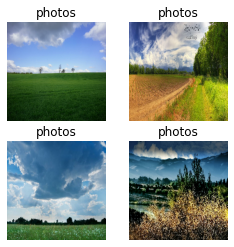

In [182]:
#construct the training GAN
gan = GANDinsky(trainingClass=trainingClass, useSampleData=useSampleData, prepForTraining=True)
gan.DisplaySamples()

In [183]:
# start the tensor board so that we can record and watch the training progress
#%tensorboard --logdir gan.StageI.TensorBoardLogDir+"/../"

##Train Stage I

In [ ]:
#StageI training was analyzed for lack of mode collapse and "well" generated images and epoch 100 was selected
iterations=1
initialIteration=1
epochs=301
stage=gan.StageI
for i in range(initialIteration,initialIteration+iterations):
  stage.Train(epochs, stage.TrainingClass + str(i))
  #stage.SaveWeights()

Epoch 1/301
8/8 [==============================] - 3s 135ms/step - d_loss: 28.6058 - g_loss: 63.6098
Epoch 2/301
8/8 [==============================] - 2s 29ms/step - d_loss: -1.8643 - g_loss: 93.7862
Epoch 3/301
8/8 [==============================] - 2s 29ms/step - d_loss: -0.6176 - g_loss: 66.3484
Epoch 4/301
8/8 [==============================] - 2s 28ms/step - d_loss: 0.1024 - g_loss: 38.4243
Epoch 5/301
8/8 [==============================] - 2s 32ms/step - d_loss: -2.0819 - g_loss: 134.8681
Epoch 6/301
8/8 [==============================] - 2s 28ms/step - d_loss: -1.5592 - g_loss: 181.6405
Epoch 7/301
8/8 [==============================] - 2s 30ms/step - d_loss: -16.2993 - g_loss: 845.8196
Epoch 8/301
8/8 [==============================] - 1s 28ms/step - d_loss: -50.9772 - g_loss: 3296.5056
Epoch 9/301
8/8 [==============================] - 2s 29ms/step - d_loss: -135.8110 - g_loss: 9556.6328
Epoch 10/301
8/8 [==============================] - 2s 30ms/step - d_loss: -695.2534 - g_

##Train Stage II


In [ ]:
#StageII training was analyzed for lack of mode collapse and "well" generated images and epoch 240 was selected
#training upto 301 as sanity check.
iterations=1
initialIteration=1
epochs=301
stage=gan.StageII
for i in range(initialIteration,initialIteration+iterations):
  stage.Train(epochs, stage.TrainingClass + str(i))
  #stage.SaveWeights()

##Image Display of Trained GAN

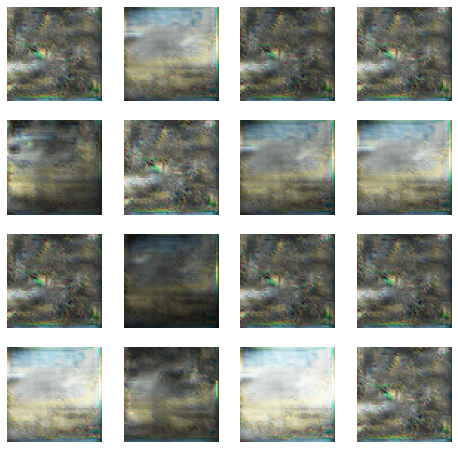

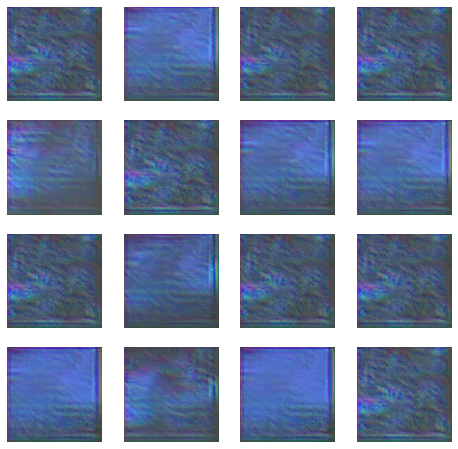

In [133]:
lrimages=[]
hrimages=[]

evalGan = gan

#create 15 images based on random input
generator_input = evalGan.StageI.GetGeneratorInput(15)
lr_generated_images = evalGan.StageI.generator(generator_input)
hr_generated_images = evalGan(generator_input)
lrimages.extend(lr_generated_images)
hrimages.extend(hr_generated_images)
#create 1 image based on test DNA Data
generator_input = dna.SampleDNAData[dna.DNAData[1]]
lr_generated_images = evalGan.StageI.generator(generator_input)
hr_generated_images = evalGan(generator_input)
lrimages.append(lr_generated_images[0])
hrimages.append(hr_generated_images[0])
#Show the sample generated low resolution image
DisplayTestImages(lrimages,(8,8))
#Show the sample generated high resolution image
DisplayTestImages(hrimages,(8,8))

# Evaluation
Execute to Evaluate either the just trained weights, or the loaded saved weights

In [ ]:
# Evaluation using Frechet Inception Distance
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.datasets.mnist import load_data
from skimage.transform import resize

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

def calculate_fid(model, images1, images2):
	#scale the images so that they all match
  images1 = scale_images(images1, (224,224,3))
  images2 = scale_images(images2, (224,224,3))
  # calculate activations
  act1 = model.predict(images1)
  act2 = model.predict(images2)
	# calculate mean and covariance statistics
  mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
  # calculate sum squared difference between means
  ssdiff = numpy.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  covmean = sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid


In [ ]:
lrimages=[]
hrimages=[] 

evalGan = GANDinsky(trainingClass=trainingClass, useSampleData=useSampleData, prepForTraining=True)
evalGan.StageI.LoadWeights() 
evalGan.StageII.LoadWeights()

#create 15 images based on random input
generator_input = evalGan.StageI.GetGeneratorInput(15)
lr_generated_images = evalGan.StageI.generator(generator_input)
hr_generated_images = evalGan(generator_input)
lrimages.extend(lr_generated_images)
hrimages.extend(hr_generated_images)

#create 1 image based on test DNA Data
generator_input = dna.SampleDNAData[dna.DNAData[1]]
lr_generated_images = evalGan.StageI.generator(generator_input)
hr_generated_images = evalGan(generator_input)
lrimages.append(lr_generated_images[0])
hrimages.append(hr_generated_images[0])

#Show the sample generated low resolution image
DisplayTestImages(lrimages,(7,7))
#Show the sample generated high resolution image
DisplayTestImages(hrimages,(7,7))

In [ ]:
# Re-initialize images to have the correct format for evaluation
from numpy import asarray
images=[]

g=evalGan
#g=evalGan.StageI.generator

#Generate a large number of images so that the average gives us a stable FID value
generator_input = evalGan.StageI.GetGeneratorInput(500)
generated_images = g(generator_input)
images.extend(generated_images)

#task on our DNA sample generated image
generator_input = dna.SampleDNAData[dna.DNAData[1]]
generated_images = g(generator_input)
images.append(generated_images[0])
image_count = len(images)

# Load original landscape images
import glob
from PIL import Image
import random
images_names = glob.glob(os.path.join(evalGan.ProjectLandscapePhotoDir, "*.jpg"))

#print((image_count))
images_true = []
for i in range(0,image_count):
  randint = random.randint(0, len(images_names) - 1)
  with open(images_names[randint], 'rb') as file:
    # the can take a long time for large numbers of files, so be patient
    img = Image.open(file)
    img = asarray(img)
    images_true.append(img)

# prepare the inception v3 model
model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(224,224,3))
# fid between images1 and images1
fid = calculate_fid(model, images, images)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images, images_true)
print('FID (different): %.3f' % fid)